In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [41]:
Max_Vocab_size=3000
Max_Sequence_Length=100
Embedding_Dim=50

In [42]:
input_texts=[]
output_texts=[]
for line in open('data-poetry/robert_frost.txt'):
    line=line.rstrip()                    # Removing right side space

    if not line:                          # if line is empty(null)
        continue

    input_line='<sos> '+line
    output_line=line+' <eos>'

    input_texts.append(input_line)
    output_texts.append(output_line)

all_lines= input_texts + output_texts

In [43]:
#input_texts
#output_texts
#all_lines

In [44]:
word_vector={}
with open('C:\LARGE FILES\GloVe\glove.6B.%sd.txt' % Embedding_Dim,'r',encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vec=np.asarray(values[1:],dtype='float32')
        word_vector[word]=vec
print('number of word_vectors=',len(word_vector))

number of word_vectors= 400000


In [45]:
tokenizer=Tokenizer(num_words=Max_Vocab_size,filters='')  
#filters ='' so that it doesnt remove special character like <> in sos and eos and other special characters
tokenizer.fit_on_texts(all_lines)
input_sequence=tokenizer.texts_to_sequences(input_texts)
target_sequence=tokenizer.texts_to_sequences(output_texts)

In [46]:
word2idx=tokenizer.word_index
assert('<sos>' in word2idx)          
# assert() is used to make sure that <sos> and <eos> are there else it will throw assertion error                                
assert('<eos>' in word2idx)
print('length of word index=',len(word2idx))

length of word index= 3056


In [47]:
word2idx

{'<sos>': 1,
 '<eos>': 2,
 'the': 3,
 'to': 4,
 'and': 5,
 'i': 6,
 'a': 7,
 'of': 8,
 'in': 9,
 'you': 10,
 'it': 11,
 'he': 12,
 'that': 13,
 'was': 14,
 'for': 15,
 'but': 16,
 'as': 17,
 'on': 18,
 'with': 19,
 'what': 20,
 'all': 21,
 'they': 22,
 'had': 23,
 'one': 24,
 'me': 25,
 'his': 26,
 'be': 27,
 'if': 28,
 'have': 29,
 'we': 30,
 'not': 31,
 'is': 32,
 'from': 33,
 'she': 34,
 'up': 35,
 'out': 36,
 'like': 37,
 'see': 38,
 'or': 39,
 'where': 40,
 'at': 41,
 'no': 42,
 'when': 43,
 'my': 44,
 'her': 45,
 'so': 46,
 'by': 47,
 'some': 48,
 "it's": 49,
 'him': 50,
 "don't": 51,
 'them': 52,
 'this': 53,
 'were': 54,
 'there': 55,
 'been': 56,
 'can': 57,
 'too': 58,
 'are': 59,
 'tell': 60,
 "he's": 61,
 'do': 62,
 'old': 63,
 "'i": 64,
 'could': 65,
 'know': 66,
 'down': 67,
 'here': 68,
 'an': 69,
 'off': 70,
 'your': 71,
 'think': 72,
 'must': 73,
 'only': 74,
 'make': 75,
 'let': 76,
 'just': 77,
 'come': 78,
 'will': 79,
 'would': 80,
 'way': 81,
 'made': 82,
 'say': 

In [48]:
# max input length of a sequnce from data=max(len(s) for s in input_sequence)
max_seq_length=min(Max_Sequence_Length,max(len(s) for s in input_sequence))

In [49]:
max_seq_length

12

In [50]:
input_data=pad_sequences(input_sequence,maxlen=max_seq_length,padding='post')
target_data=pad_sequences(target_sequence,maxlen=max_seq_length,padding='post')

In [51]:
num_words=min(Max_Vocab_size,len(word2idx)+1)
embedding_matrix=np.zeros((num_words,Embedding_Dim))
for word,i in word2idx.items():
    if i<Max_Vocab_size:
        embedding_vec=word_vector.get(word)
        if embedding_vec is not None:
            embedding_matrix[i]=embedding_vec

In [54]:
one_hot_targets=np.zeros((len(input_data),max_seq_length,num_words))
print(one_hot_targets[3][9])    #(i,row=ek line,column= 12 words-jisko num_words me represent krke likhenge)-[0,0,......1,...,0,0]
for i,target_sequence in enumerate(target_data):
    for t,word in enumerate(target_sequence):
        if word>0:
           one_hot_targets[i,t,word]=1
print(one_hot_targets[3][9])

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]


In [55]:
len(word2idx)

3056

In [59]:
embedding_layer=Embedding(num_words,
                         Embedding_Dim,
                         weights=[embedding_matrix],
                         input_length=max_seq_length,
                         trainable=False)

In [60]:
Latent_Dim=25
input_=Input(shape=(max_seq_length,))
input_h=Input(shape=(Latent_Dim,))
input_c=Input(shape=(Latent_Dim,))
x=embedding_layer(input_)
lstm=LSTM(Latent_Dim,return_sequences=True,return_state=True)
x, _, _=lstm(x,initial_state=[input_h,input_c])                
#we dont need sequences and state here we will use it later on
dense=Dense(num_words,activation='softmax')
output=dense(x)

In [61]:
model=Model([input_,input_h,input_c],output)

In [62]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 12, 50)       150000      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                              

In [64]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])               
#Accuracy dont do much eg is first word is 'the' then after it any word can be there

In [65]:
# Initializing the initial h and c
z=np.zeros((len(input_data),Latent_Dim))
model.fit([input_data,z,z],
          one_hot_targets,
          epochs=2000,
          batch_size=128,
          validation_split=0.2)

Epoch 1/2000
9/9 [==============================] - 8s 106ms/step - loss: 5.3974 - accuracy: 0.0578 - val_loss: 5.0632 - val_accuracy: 0.0833
Epoch 2/2000
9/9 [==============================] - 0s 21ms/step - loss: 4.6426 - accuracy: 0.0834 - val_loss: 4.7894 - val_accuracy: 0.0833
Epoch 3/2000
9/9 [==============================] - 0s 21ms/step - loss: 4.4501 - accuracy: 0.0833 - val_loss: 4.8347 - val_accuracy: 0.0833
Epoch 4/2000
9/9 [==============================] - 0s 21ms/step - loss: 4.4215 - accuracy: 0.0833 - val_loss: 4.8881 - val_accuracy: 0.0833
Epoch 5/2000
9/9 [==============================] - 0s 21ms/step - loss: 4.4171 - accuracy: 0.0881 - val_loss: 4.8634 - val_accuracy: 0.0871
Epoch 6/2000
9/9 [==============================] - 0s 21ms/step - loss: 4.3821 - accuracy: 0.0912 - val_loss: 4.8241 - val_accuracy: 0.0871
Epoch 7/2000
9/9 [==============================] - 0s 20ms/step - loss: 4.3590 - accuracy: 0.0912 - val_loss: 4.8037 - val_accuracy: 0.0871
Epoch 8/2000

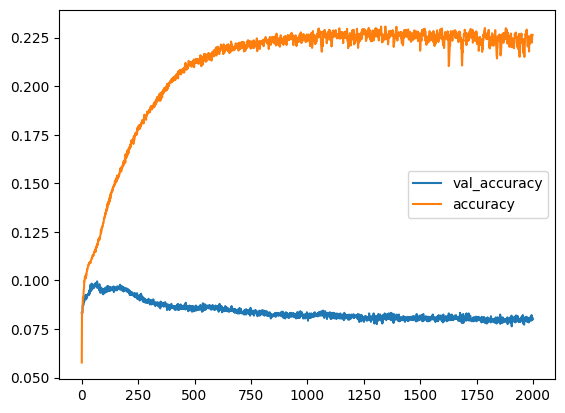

In [66]:
plt.plot(model.history.history['val_accuracy'],label='val_accuracy')
plt.plot(model.history.history['accuracy'],label='accuracy')
plt.legend()

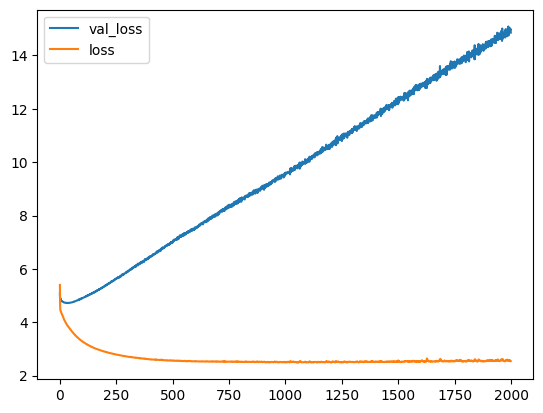

In [67]:
plt.plot(model.history.history['val_loss'],label='val_loss')
plt.plot(model.history.history['loss'],label='loss')
plt.legend()

In [68]:
#Sampling model for prediction
input2=Input(shape=(1,))       # We will only use one word at a time
x=embedding_layer(input2)
x,h,c=lstm(x,initial_state=[input_h,input_c])  # Now we would require hiddem states and sequences        
output2=dense(x)
Sampling_model=Model([input2,input_h,input_c],[output2,h,c])

In [69]:
idx2word={v:k for k,v in word2idx.items()}

In [74]:
# function for creating one line of code
def sample_line():
    np_input=np.array([[word2idx['<sos>']]])
    h=np.zeros((1,Latent_Dim))
    c=np.zeros((1,Latent_Dim))

    eos=word2idx['<eos>']
    output_sentence=[]

    for _ in range(max_seq_length):
        o,h,c=Sampling_model.predict([np_input,h,c],verbose=0)
        #print(o.shape())
        probs=o[0,0]
        if(np.argmax(probs)==0):
            print('wtf')
        probs[0]=0
        probs/=probs.sum()
        idx=np.random.choice(len(probs),p=probs)
        if idx==eos:
            break

        output_sentence.append(idx2word.get(idx,'wtf %s' % idx))

        np_input[0,0]=idx
        
    return ' '.join(output_sentence)        

In [75]:
#generate 4 line poem
while True:
    for _ in range(4):
        print(sample_line())
    ans=input('Generate another verse? [Y/N]:')
    if ans and ans[0].lower().startswith('n'):
        break

'four been seen the storm old it's shouldn't light was, times see?
in his with blew itself talking. if numerous mountain turned glass: how
'today.' tell know a soul vines?'
'it's i showed arthur amy auk!' do. day youthful in front picking


Generate another verse? [Y/N]: n
